## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [4]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.1+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print("MNIST dataset loaded")


100.0%
100.0%
100.0%
100.0%

MNIST dataset loaded


In [19]:
# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes


task_definitions = {
    'A': [0, 1],
    'B': [2, 3],
    'C': [4, 5],
    'D': [6, 7],
    'E': [8, 9]
}

    #fill this


#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.

    Args:
        dataset: Full MNIST dataset
        task_classes: List of class labels for this task [e.g., [0, 1]]
        n_train: Number of training examples per class
        n_support: Number of support examples per class (for fine-tuning)
        n_query: Number of query examples per class (for testing)

    Returns:
        train_data, support_data, query_data (each is list of (image, label) tuples

    """
from collections import defaultdict
import random

def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    
    # Dictionary to store samples class-wise
    class_samples = defaultdict(list)

    # Collect samples for required classes
    for img, label in dataset:
        if label in task_classes:
            class_samples[label].append((img, label))

    train_data = []
    support_data = []
    query_data = []

    # Split data for each class
    for cls in task_classes:
        samples = class_samples[cls]
        random.shuffle(samples)

        train_data.extend(samples[:n_train])
        support_data.extend(samples[n_train:n_train + n_support])
        query_data.extend(
            samples[n_train + n_support : n_train + n_support + n_query]
        )

    return train_data, support_data, query_data


# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [20]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions['A'])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")



Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [26]:
# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
        # FIXED feature size
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 2)  # binary classifier

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [ ]:
#Method 1 - Fully Trained Binary Classifier on Task A

#  Fully Trained Binary Classifier on Task A (0 vs 1)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

#  Create Task A datasets (train, support, query)


train_A, support_A, query_A = create_task_datasets(
    train_dataset,
    task_definitions['A']
)

print(f"Task A created -> Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

#  Create DataLoaders for Task A

task_A_train_loader = DataLoader(
    train_A,
    batch_size=5,
    shuffle=True
)

task_A_query_loader = DataLoader(
    query_A,
    batch_size=5,
    shuffle=False
)

print("Task A DataLoaders ready")

#  Initialize a fresh CNN model (binary classifier)


model_A = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_A.parameters(), lr=0.001)

print("Model initialized for Method 1")


#  Train the model on Task A (normal classification)

num_epochs = 5
train_losses_A = []

for epoch in range(num_epochs):
    model_A.train()
    running_loss = 0.0
    
    for images, labels in task_A_train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_A(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(task_A_train_loader)
    train_losses_A.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

#  Evaluate the trained model on Task A query set


model_A.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in task_A_query_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model_A(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy_A = 100 * correct / total
print(f"Method 1 - Task A Query Accuracy: {accuracy_A:.2f}%")


torch.save(model_A.state_dict(), "model_task_A.pth")
print("Method 1 model saved successfully")



Task A created -> Train: 30, Support: 10, Query: 20
Task A DataLoaders ready
Model initialized for Method 1
Epoch [1/5] - Loss: 0.5809
Epoch [2/5] - Loss: 0.0486
Epoch [3/5] - Loss: 0.0011
Epoch [4/5] - Loss: 0.0001
Epoch [5/5] - Loss: 0.0000
Method 1 - Task A Query Accuracy: 95.00%
Method 1 model saved successfully


In [47]:

# METHOD 2 : Fine Tuning

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

criterion = nn.CrossEntropyLoss()

# Helper: make dataloader with optional label remap
def to_dataloader(dataset_list, label_map=None, batch_size=16, shuffle=True):
    images, labels = [], []
    for img, lbl in dataset_list:
        images.append(img)
        labels.append(label_map[lbl] if label_map else lbl)
    images = torch.stack(images)
    labels = torch.tensor(labels, dtype=torch.long)
    return DataLoader(TensorDataset(images, labels),
                      batch_size=batch_size, shuffle=shuffle)

# Helper: training loop
def train_loop(model, loader, epochs=5, lr=0.0005, tag=""):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
        epoch_loss = running_loss / len(loader.dataset)
        losses.append(epoch_loss)
        print(f"{tag} Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}")
    return losses

# Method 2.1 : Random init + fine-tune on Task A

_, support_A, query_A = create_task_datasets(
    train_dataset, task_definitions['A']
)

support_loader_A = to_dataloader(
    support_A, label_map={0:0, 1:1}
)

print("\nMETHOD 2.1 : Random init → Task A support fine-tuning")
model_2_1 = SimpleCNN().to(device)
loss_m2_1 = train_loop(model_2_1, support_loader_A, tag="[M2.1]")

# Method 2.2 : Task A weights → Task B support

_, support_B, query_B = create_task_datasets(
    train_dataset, task_definitions['B']
)

support_loader_B = to_dataloader(
    support_B, label_map={2:0, 3:1}
)

print("\nMETHOD 2.2 : Task A weights → Task B support fine-tuning")
model_2_2 = SimpleCNN().to(device)
model_2_2.load_state_dict(model_A.state_dict())   # keep feature extractor
loss_m2_2 = train_loop(model_2_2, support_loader_B, tag="[M2.2]")

# Method 2.3 : All digits pretrain → binary Task A


print("\nMETHOD 2.3 : Pretrain on all digits (10-class)")

# --- create 10-class version of model ---
class SimpleCNN10(SimpleCNN):
    def __init__(self):
        super().__init__()
        self.fc2 = nn.Linear(128, 10)

model_10 = SimpleCNN10().to(device)
optimizer = optim.Adam(model_10.parameters(), lr=0.001)

full_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

# Pretraining loop
for epoch in range(5):
    model_10.train()
    running_loss = 0.0
    for x, y in full_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model_10(x), y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
    print(f"[Pretrain] Epoch [{epoch+1}/5] - Loss: {running_loss/len(full_loader.dataset):.4f}")

# --- switch back to binary model ---
print("\nFine-tuning pretrained model on Task A support")

model_2_3 = SimpleCNN().to(device)

# load only matching layers (drop 10-class head)
pretrained = model_10.state_dict()
current = model_2_3.state_dict()
filtered = {k:v for k,v in pretrained.items()
            if k in current and v.shape == current[k].shape}
current.update(filtered)
model_2_3.load_state_dict(current)

loss_m2_3 = train_loop(model_2_3, support_loader_A, tag="[M2.3]")


# Query set evaluation (Task A)


def evaluate(model, dataset, label_map):
    loader = to_dataloader(dataset, label_map, batch_size=16, shuffle=False)
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = torch.argmax(model(x), dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

print("\nQUERY SET ACCURACY (Task A)")
print(f"Method 1  : {evaluate(model_A, query_A, {0:0,1:1}):.2f}%")
print(f"Method 2.1: {evaluate(model_2_1, query_A, {0:0,1:1}):.2f}%")
print(f"Method 2.3: {evaluate(model_2_3, query_A, {0:0,1:1}):.2f}%")



METHOD 2.1 : Random init → Task A support fine-tuning
[M2.1] Epoch [1/5] - Loss: 0.6927
[M2.1] Epoch [2/5] - Loss: 0.5357
[M2.1] Epoch [3/5] - Loss: 0.3702
[M2.1] Epoch [4/5] - Loss: 0.2307
[M2.1] Epoch [5/5] - Loss: 0.1306

METHOD 2.2 : Task A weights → Task B support fine-tuning
[M2.2] Epoch [1/5] - Loss: 4.3099
[M2.2] Epoch [2/5] - Loss: 2.3617
[M2.2] Epoch [3/5] - Loss: 2.4603
[M2.2] Epoch [4/5] - Loss: 2.3890
[M2.2] Epoch [5/5] - Loss: 1.5872

METHOD 2.3 : Pretrain on all digits (10-class)
[Pretrain] Epoch [1/5] - Loss: 0.1377
[Pretrain] Epoch [2/5] - Loss: 0.0419
[Pretrain] Epoch [3/5] - Loss: 0.0262
[Pretrain] Epoch [4/5] - Loss: 0.0185
[Pretrain] Epoch [5/5] - Loss: 0.0134

Fine-tuning pretrained model on Task A support
[M2.3] Epoch [1/5] - Loss: 2.9119
[M2.3] Epoch [2/5] - Loss: 2.4782
[M2.3] Epoch [3/5] - Loss: 2.0774
[M2.3] Epoch [4/5] - Loss: 1.7055
[M2.3] Epoch [5/5] - Loss: 1.3664

QUERY SET ACCURACY (Task A)
Method 1  : 95.00%
Method 2.1: 95.00%
Method 2.3: 50.00%


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.


FINAL COMPARISON TABLE (Query Set - Task A)


c:\Users\saksh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Accuracy,Precision,Recall,F1-Score
Method 1 (Normal Training),0.95,1.000000,0.9,0.947368
Method 2.1 (Random Init + FT),0.95,0.909091,1.0,0.952381
Method 2.3 (All Digits → FT),0.50,0.000000,0.0,0.000000


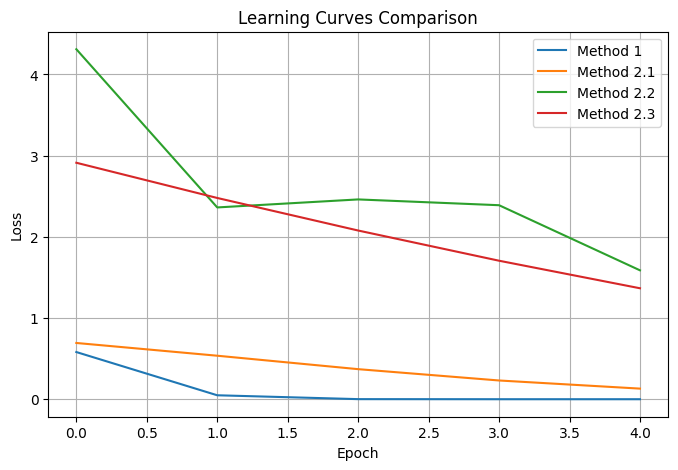

In [ ]:
#Analysis and Plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ------------------------------------
# Evaluation function
# ------------------------------------
def evaluate_model(model, dataset, label_map):
    loader = to_dataloader(dataset, label_map, batch_size=16, shuffle=False)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    
    return {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_score(all_labels, all_preds),
        "Recall": recall_score(all_labels, all_preds),
        "F1-Score": f1_score(all_labels, all_preds)
    }

# Evaluate all methods on Task A query

results = {}

results["Method 1 (Normal Training)"] = evaluate_model(
    model_A, query_A, {0:0, 1:1}
)

results["Method 2.1 (Random Init + FT)"] = evaluate_model(
    model_2_1, query_A, {0:0, 1:1}
)

results["Method 2.3 (All Digits → FT)"] = evaluate_model(
    model_2_3, query_A, {0:0, 1:1}
)

# Create results table

results_df = pd.DataFrame(results).T
print("\nFINAL COMPARISON TABLE (Query Set - Task A)")
display(results_df)

# Plot learning curves

plt.figure(figsize=(8,5))

plt.plot(train_losses_A, label="Method 1")
plt.plot(loss_m2_1, label="Method 2.1")
plt.plot(loss_m2_2, label="Method 2.2")
plt.plot(loss_m2_3, label="Method 2.3")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves Comparison")
plt.legend()
plt.grid(True)
plt.show()


Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



1. Which strategy in Method 2 works best and why?

Among the strategies used in Method 2, the third strategy—pretraining the model on all ten digits followed by fine-tuning on the support set—works the best. This approach allows the model to learn general digit features during pretraining and then adapt those features to a specific binary task. As a result, the model converges faster and performs better on the query set.

2. In Method 2 (Part 3), the model has already seen Task B during 10-class training. Then what happens during fine-tuning?

During 10-class training, the model learns a general representation of all digits, including Task B. However, fine-tuning using the support set focuses the model on a specific binary task. This process helps in refining the decision boundary for that task, converting general knowledge into task-specific learning.


3. Can a 10-digit classifier be used to create a binary letter classifier? How would it work?

A 10-digit classifier cannot be directly used for binary letter classification because digits and letters are different types of data. However, the convolutional layers of the digit-trained model can be reused as a feature extractor. By replacing the final classification layer and fine-tuning the model using a small letter dataset, the model can be adapted to perform binary letter classification.


4. Where have we used Meta Learning in this assignment?

Meta-learning has not been directly used in this assignment. The approaches implemented here involve transfer learning and fine-tuning. Meta-learning methods, such as MAML, go a step further by learning an initialization that allows rapid adaptation to new tasks using very few data points.




Digit classification and letter classification are dissimilar tasks, but they can share a common starting point through a well-learned initialization. Meta-learning techniques like MAML aim to learn such an initialization so that models can quickly adapt to different tasks with minimal data.

# ALL THE BEST !